In [1]:
# -----------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee (July 2018) 
#
# Encode Pseudomonas gene expression data into low dimensional latent space using 
# Tybalt with 2-hidden layers
# --------------------------------------------------------------------------------------------------------------------
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# To ensure reproducibility using Keras during development
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
randomState = 123
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import metrics, optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Files
# --------------------------------------------------------------------------------------------------------------------
data_file =  os.path.join(os.path.dirname(os.getcwd()), "data", "oxygen_level", "train_model_input.txt.xz")
rnaseq = pd.read_table(data_file,sep='\t',index_col=0, header=0, compression='xz')

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Initialize hyper parameters
#
# learning rate: 
# batch size: Total number of training examples present in a single batch
#             Iterations is the number of batches needed to complete one epoch
# epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
# kappa: warmup
# original dim: dimensions of the raw data
# latent dim: dimensiosn of the latent space (fixed by the user)
#   Note: intrinsic latent space dimension unknown
# epsilon std: 
# beta: Threshold value for ReLU?
# --------------------------------------------------------------------------------------------------------------------

learning_rate = 0.001
batch_size = 100
epochs = 500
kappa = 0.01

original_dim = rnaseq.shape[1]
intermediate_dim = 100
latent_dim = 10
epsilon_std = 1.0
beta = K.variable(0)

stat_file =  os.path.join(os.path.dirname(os.getcwd()), "stats", "oxygen_level", "tybalt_2layer_{}latent_stats.csv".format(latent_dim))
hist_plot_file =os.path.join(os.path.dirname(os.getcwd()), "stats", "oxygen_level", "tybalt_2layer_{}latent_hist.png".format(latent_dim))

encoded_file =os.path.join(os.path.dirname(os.getcwd()), "encoded", "oxygen_level", "train_input_2layer_{}latent_encoded.txt".format(latent_dim))

model_encoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "oxygen_level", "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim))
weights_encoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "oxygen_level", "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim))
model_decoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "oxygen_level", "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim))
weights_decoder_file =os.path.join(os.path.dirname(os.getcwd()), "models", "oxygen_level", "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim))

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Functions
#
# Based on publication by Greg et. al. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5728678/
# https://github.com/greenelab/tybalt/blob/master/scripts/vae_pancancer.py
# --------------------------------------------------------------------------------------------------------------------

# Function for reparameterization trick to make model differentiable
def sampling(args):

    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)

    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * \
                              metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded -
                                K.square(z_mean_encoded) -
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [5]:
# --------------------------------------------------------------------------------------------------------------------
# Data initalizations
# --------------------------------------------------------------------------------------------------------------------

# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq.sample(frac=test_set_percent, random_state = randomState)
rnaseq_train_df = rnaseq.drop(rnaseq_test_df.index)

# Create a placeholder for an encoded (original-dimensional)
rnaseq_input = Input(shape=(original_dim, ))

In [6]:
# --------------------------------------------------------------------------------------------------------------------
# Architecture of VAE
# --------------------------------------------------------------------------------------------------------------------

# ENCODER

# Input layer is compressed into a mean and log variance vector of size
# `latent_dim`. Each layer is initialized with glorot uniform weights and each
# step (dense connections, batch norm,and relu activation) are funneled
# separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

# "z_mean_dense_linear" is the encoded representation of the input
#    Take as input arrays of shape (*, original dim) and output arrays of shape (*, latent dim)
#    Combine input from previous layer using linear summ
# Normalize the activations (combined weighted nodes of the previous layer)
#   Transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
# Apply ReLU activation function to combine weighted nodes from previous layer
#   relu = threshold cutoff (cutoff value will be learned)
#   ReLU function filters noise

# X is encoded using Q(z|X) to yield mu(X), sigma(X) that describes latent space distribution
hidden_dense_linear = Dense(intermediate_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

# Note:
# Normalize and relu filter at each layer adds non-linear component (relu is non-linear function)
# If architecture is layer-layer-normalization-relu then the computation is still linear
# Add additional layers in triplicate
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# Customized layer
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
#
# sampling():
# randomly sample similar points z from the latent normal distribution that is assumed to generate the data,
# via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor
# z ~ Q(z|X)
# Note: there is a trick to reparameterize to standard normal distribution so that the space is differentiable and 
# therefore gradient descent can be used
#
# Returns the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a
# latent_dim` output
z = Lambda(sampling,
           output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])


# DECODER

# The decoding layer is much simpler with a single layer glorot uniform
# initialized and sigmoid activation
# Reconstruct P(X|z)
decoder_model = Sequential()
decoder_model.add(Dense(intermediate_dim, activation='relu', input_dim=latent_dim))
decoder_model.add(Dense(original_dim, activation='sigmoid'))
rnaseq_reconstruct = decoder_model(z)


# CONNECTIONS
# fully-connected network
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/ipykernel/__main__.py:74: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [7]:
# --------------------------------------------------------------------------------------------------------------------
# Training
# --------------------------------------------------------------------------------------------------------------------

# fit Model
# hist: record of the training loss at each epoch
hist = vae.fit(np.array(rnaseq_train_df), shuffle=True, epochs=epochs, batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa)])

Train on 1061 samples, validate on 118 samples
Epoch 1/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3750.1025 - val_loss: 3595.9475
Epoch 2/500
1061/1061 [==============================] - 1s 903us/step - loss: 3587.8393 - val_loss: 3580.5758
Epoch 3/500
1061/1061 [==============================] - 1s 901us/step - loss: 3526.6957 - val_loss: 3648.0841
Epoch 4/500
1061/1061 [==============================] - 1s 883us/step - loss: 3506.5969 - val_loss: 3629.4877
Epoch 5/500
1061/1061 [==============================] - 1s 888us/step - loss: 3493.7799 - val_loss: 3550.2845
Epoch 6/500
1061/1061 [==============================] - 1s 883us/step - loss: 3485.8599 - val_loss: 3505.7038
Epoch 7/500
1061/1061 [==============================] - 1s 905us/step - loss: 3483.1250 - val_loss: 3476.6030
Epoch 8/500
1061/1061 [==============================] - 1s 900us/step - loss: 3478.9141 - val_loss: 3454.1565
Epoch 9/500
1061/1061 [==============================] - 1s 882us/s

1061/1061 [==============================] - 1s 959us/step - loss: 3390.4417 - val_loss: 3366.2920
Epoch 75/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3392.4213 - val_loss: 3366.3049
Epoch 76/500
1061/1061 [==============================] - 1s 979us/step - loss: 3391.8411 - val_loss: 3368.0148
Epoch 77/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3388.9897 - val_loss: 3370.8780
Epoch 78/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3389.2491 - val_loss: 3363.5315
Epoch 79/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3389.5229 - val_loss: 3364.2948
Epoch 80/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3388.1799 - val_loss: 3365.9687
Epoch 81/500
1061/1061 [==============================] - 1s 959us/step - loss: 3387.0526 - val_loss: 3361.7317
Epoch 82/500
1061/1061 [==============================] - 1s 1ms/step - loss: 3387.9043 - val_loss: 3363.1355
Epoch 83/500
1061

1061/1061 [==============================] - 1s 943us/step - loss: 3361.0503 - val_loss: 3340.8426
Epoch 148/500
1061/1061 [==============================] - 1s 913us/step - loss: 3359.0168 - val_loss: 3340.3242
Epoch 149/500
1061/1061 [==============================] - 1s 915us/step - loss: 3359.6738 - val_loss: 3344.3498
Epoch 150/500
1061/1061 [==============================] - 1s 906us/step - loss: 3358.5594 - val_loss: 3342.1230
Epoch 151/500
1061/1061 [==============================] - 1s 902us/step - loss: 3359.0117 - val_loss: 3343.7702
Epoch 152/500
1061/1061 [==============================] - 1s 894us/step - loss: 3358.1419 - val_loss: 3342.4411
Epoch 153/500
1061/1061 [==============================] - 1s 929us/step - loss: 3357.8195 - val_loss: 3341.9423
Epoch 154/500
1061/1061 [==============================] - 1s 876us/step - loss: 3358.1234 - val_loss: 3339.4992
Epoch 155/500
1061/1061 [==============================] - 1s 914us/step - loss: 3357.5398 - val_loss: 3340.37

1061/1061 [==============================] - 1s 890us/step - loss: 3343.7503 - val_loss: 3328.2617
Epoch 220/500
1061/1061 [==============================] - 1s 889us/step - loss: 3343.8693 - val_loss: 3324.4758
Epoch 221/500
1061/1061 [==============================] - 1s 903us/step - loss: 3344.7925 - val_loss: 3324.5782
Epoch 222/500
1061/1061 [==============================] - 1s 906us/step - loss: 3341.8474 - val_loss: 3325.0796
Epoch 223/500
1061/1061 [==============================] - 1s 900us/step - loss: 3343.5876 - val_loss: 3328.4225
Epoch 224/500
1061/1061 [==============================] - 1s 884us/step - loss: 3342.6914 - val_loss: 3325.1673
Epoch 225/500
1061/1061 [==============================] - 1s 879us/step - loss: 3342.7899 - val_loss: 3326.5098
Epoch 226/500
1061/1061 [==============================] - 1s 876us/step - loss: 3342.3244 - val_loss: 3326.4549
Epoch 227/500
1061/1061 [==============================] - 1s 883us/step - loss: 3343.1666 - val_loss: 3326.36

1061/1061 [==============================] - 1s 919us/step - loss: 3333.3062 - val_loss: 3317.5975
Epoch 292/500
1061/1061 [==============================] - 1s 947us/step - loss: 3331.7955 - val_loss: 3318.4345
Epoch 293/500
1061/1061 [==============================] - 1s 897us/step - loss: 3333.4940 - val_loss: 3318.1449
Epoch 294/500
1061/1061 [==============================] - 1s 889us/step - loss: 3332.4035 - val_loss: 3319.6803
Epoch 295/500
1061/1061 [==============================] - 1s 890us/step - loss: 3333.9346 - val_loss: 3316.8204
Epoch 296/500
1061/1061 [==============================] - 1s 899us/step - loss: 3331.7283 - val_loss: 3316.1605
Epoch 297/500
1061/1061 [==============================] - 1s 859us/step - loss: 3332.1473 - val_loss: 3317.8885
Epoch 298/500
1061/1061 [==============================] - 1s 884us/step - loss: 3332.7644 - val_loss: 3313.5045
Epoch 299/500
1061/1061 [==============================] - 1s 814us/step - loss: 3331.9197 - val_loss: 3317.61

1061/1061 [==============================] - 1s 949us/step - loss: 3326.1248 - val_loss: 3311.9689
Epoch 364/500
1061/1061 [==============================] - 1s 905us/step - loss: 3325.3518 - val_loss: 3314.1212
Epoch 365/500
1061/1061 [==============================] - 1s 905us/step - loss: 3325.5406 - val_loss: 3312.2366
Epoch 366/500
1061/1061 [==============================] - 1s 896us/step - loss: 3325.2545 - val_loss: 3313.1704
Epoch 367/500
1061/1061 [==============================] - 1s 883us/step - loss: 3324.7645 - val_loss: 3309.9215
Epoch 368/500
1061/1061 [==============================] - 1s 892us/step - loss: 3325.0292 - val_loss: 3310.0257
Epoch 369/500
1061/1061 [==============================] - 1s 910us/step - loss: 3326.4422 - val_loss: 3314.5290
Epoch 370/500
1061/1061 [==============================] - 1s 889us/step - loss: 3325.8013 - val_loss: 3311.5540
Epoch 371/500
1061/1061 [==============================] - 1s 899us/step - loss: 3325.0688 - val_loss: 3309.45

1061/1061 [==============================] - 1s 880us/step - loss: 3319.8198 - val_loss: 3307.1973
Epoch 436/500
1061/1061 [==============================] - 1s 884us/step - loss: 3319.7819 - val_loss: 3307.0967
Epoch 437/500
1061/1061 [==============================] - 1s 892us/step - loss: 3320.2328 - val_loss: 3309.4351
Epoch 438/500
1061/1061 [==============================] - 1s 913us/step - loss: 3320.3531 - val_loss: 3307.1361
Epoch 439/500
1061/1061 [==============================] - 1s 903us/step - loss: 3320.3333 - val_loss: 3307.9234
Epoch 440/500
1061/1061 [==============================] - 1s 893us/step - loss: 3319.6201 - val_loss: 3307.0996
Epoch 441/500
1061/1061 [==============================] - 1s 891us/step - loss: 3320.2125 - val_loss: 3306.1893
Epoch 442/500
1061/1061 [==============================] - 1s 829us/step - loss: 3320.7294 - val_loss: 3306.8900
Epoch 443/500
1061/1061 [==============================] - 1s 911us/step - loss: 3319.8058 - val_loss: 3306.15

In [8]:
# --------------------------------------------------------------------------------------------------------------------
# Use trained model to make predictions
# --------------------------------------------------------------------------------------------------------------------
encoder = Model(rnaseq_input, z_mean_encoded)

encoded_rnaseq_df = encoder.predict_on_batch(rnaseq)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1

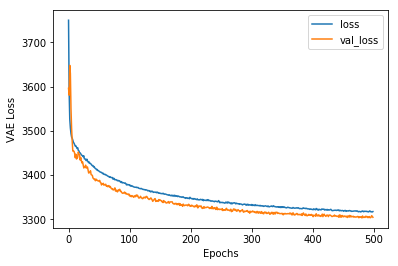

In [9]:
# --------------------------------------------------------------------------------------------------------------------
# Visualize training performance
# --------------------------------------------------------------------------------------------------------------------
history_df = pd.DataFrame(hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [10]:
# --------------------------------------------------------------------------------------------------------------------
# Output
# --------------------------------------------------------------------------------------------------------------------

# Save training performance
history_df = pd.DataFrame(hist.history)
history_df = history_df.assign(learning_rate=learning_rate)
history_df = history_df.assign(batch_size=batch_size)
history_df = history_df.assign(epochs=epochs)
history_df = history_df.assign(kappa=kappa)
history_df.to_csv(stat_file, sep='\t')

# Save latent space representation
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

# Save models
# (source) https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# Save encoder model
encoder.save(model_encoder_file)
    
# serialize weights to HDF5
encoder.save_weights(weights_encoder_file)

# Save decoder model
# (source) https://github.com/greenelab/tybalt/blob/master/scripts/nbconverted/tybalt_vae.py
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_model(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

decoder.save(model_decoder_file)
    
# serialize weights to HDF5
decoder.save_weights(weights_decoder_file)